# Description:
This program is for ASTR400B Project.  It will choose a snapshot and bin particles in that snapshot.  It will compare how the particles from each bin are changing during the merger of Andromeda and the Milky Way.  The main focus is to look at the tidal arms and bridges of created and where the particles came from in the merger.  

Authur: Andrew Henrici  
Date last modified: 4/19/2018

In [1]:
%matplotlib notebook
# Import analysis packages
import numpy as np
from scipy import stats
from scipy import interpolate
import astropy.units as u
import pandas as pd

# Import plotting packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Import my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from RotateFrame import RotateFrame
from Binmaker import binmaker

In [2]:
def GetData(filename):
    # Store the COM of the Milky Way to center on
    COMD = CenterOfMass(filename, 2)
    COMP = COMD.COM_P(0.1, 4.0)
    COMV = COMD.COM_V(COMP[0], COMP[1], COMP[2])

    # Recenter to COM position
    xD = COMD.x - float(COMP[0]/u.kpc)
    yD = COMD.y - float(COMP[1]/u.kpc)
    zD = COMD.z - float(COMP[2]/u.kpc)
    
    # Recenter to COM velocity
    vxD = COMD.vx - float(COMV[0]/(u.km/u.s))
    vyD = COMD.vy - float(COMV[1]/(u.km/u.s))
    vzD = COMD.vz - float(COMV[2]/(u.km/u.s))
    
    # Store as arrays
    pos = np.array([xD, yD, zD]).T
    vel = np.array([vxD, vyD, vzD]).T
    
    pos, vel = RotateFrame(pos, vel)
    
    return pos


# Find the nearest five particles in the bin and get the distances of them
def nearest_five(data):
    n5 = np.ones((len(data), 5))*r0
    for i in range(len(data)):
        for j in range(len(data)):
            if j != i:
                r = np.sqrt((data[i,0] - data[j,0])**2+(data[i,1] - data[j,1])**2+(data[i,2] - data[j,2])**2)
                for k in range(5):
                    if n5[i,k] == r0 and r<n5[i,k]:
                        n5[i,k] = r
                        break
    return n5

# Bins the particles to the closest test point(point on curve fit).
# Each particle is given the number of the closest stored in index
def Find_Local(data, points):
    index = np.zeros(len(data))
    for j in range(len(data)):
        d = data[j]
        delta_r = 1000
        closest_point = 0
        for i in range(len(points)):
            p = points[i]
            r = np.sqrt((d[0]-p[0])**2 + (d[1]-p[1])**2 + (d[2]-p[2])**2)
            if r < delta_r:
                delta_r = r
                closest_point = i
        index[j] = closest_point
    return index


def recenter(data, points, index):
    new_list = np.zeros((len(points),3), dtype = float)
    for i in range(len(points)):
        p = points[i]
        close = data[np.where(index == i)]
        fx, fy, fz = 0, 0, 0
        for c in close:
            fx += c[0]/len(close)
            fy += c[1]/len(close)
            fz += c[2]/len(close)
        new_list[i, 0] = fx
        new_list[i, 1] = fy
        new_list[i, 2] = fz
    return new_list


# Finds the mean for all of the non-zero values and valuat ain't ro
def Mean(inputs):
    good_inp = []
    for i in range(len(inputs)):
        if inputs[i] != ro:
            good_inp.append(inputs[i])
    return sum(good_inp)/len(good_inp)


def cut_err(x, a, err, c):
    y = cut_function(x, a, 0, c)
    y_upr = cut_function(x, a, err, c)
    y_lwr = cut_function(x, a, -err, c)
    return y, y_upr, y_lwr


def cut_function(x, a, b, c):
    return a*np.sin((x-b)/c)


def Cutter(data, a, err, c):
    # Plot the cut regions
    fig = plt.figure()
    
    xD, yD, zD = data[:,0], data[:,1], data[:,2]
    
    # plot the cuts

    plt.xlim(-100.,100.)
    plt.ylim(-100.,100.)

    Y = np.linspace(-100., 100., 100)
    
    X, X_upr, X_lwr = cut_err(Y, a, err, c)
    plt.plot(X_upr, Y, '--')
    plt.plot(X, Y, '--')
    plt.plot(X_lwr, Y,'--')

    lower_index = np.where(xD >= cut_function(yD, a, err, c))
    upper_index = np.where(xD <= cut_function(yD, a, -err, c))

    xl, yl, zl = xD[lower_index], yD[lower_index], zD[lower_index]
    xu, yu, zu = xD[upper_index], yD[upper_index], zD[upper_index]

    plt.plot(xl, yl, ',')
    plt.plot(xu, yu, ',')
    
    return upper_index, lower_index

In [4]:
# Global values

# Comparison radius for n5
ro = 1000

# Define list of colors to cycle through
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple']

# Decide number of bins
N_Rad = 7
N_Ang = 4

# Snapshot numbers
snapshot0 = 275
snapshotf = 300

# What to compare
Galaxy = 'M31'
direction = 'lower'

a, err, c = -35, 30, 50

test_points = np.array([[15, 10, 0],
                        [24, 9, 0],
                        [32, 2, 0],
                        [38, -16, 0],
                        [40, -30, 0]])


# File names for both timesteps
fname0 = "{}_{}".format(Galaxy, snapshot0)
fnamef = "{}_{}".format(Galaxy, snapshotf)

In [ ]:
data0 = GetData("{}.txt".format(fname0))
bin_t0 = binmaker(data0)
Radial0 = bin_t0.Radial_Bins(N_Rad)

dataf = GetData("{}.txt".format(fnamef))
bin_tf = binmaker(dataf)
Radialf = bin_tf.Radial_Bins(N_Rad)

In [ ]:
fig = plt.figure()
plt.xlim(-100, 100)
plt.ylim(-100, 100)
for i in range(N_Rad):
    index = np.where(Radial0 == i)
    plt.plot(dataf[index, 0][0], dataf[index, 1][0], ',', color=colors[i])
plt.savefig("{}_pos.png".format(fnamef))

In [ ]:
upr_index, lwr_index = Cutter(dataf, a, err, c)

plt.

if direction =='upper':
    x, y, z = dataf[upr_index, 0][0], dataf[upr_index,1][0], dataf[upr_index,2][0]
    bin_t0 = binmaker(data0[upr_index])
elif direction =='lower':
    x, y, z = dataf[lwr_index,0][0], dataf[lwr_index,1][0], dataf[lwr_index,2][0]
    bin_t0 = binmaker(data0[lwr_index])
    

In [ ]:
# Plot the test points of the spline
fig = plt.figure()

plt.plot(x, y, 'k,')
plt.plot(test_points[:,0], test_points[:,1], linewidth=4)

tck, _u = interpolate.splprep([test_points[:,0], test_points[:,1], test_points[:, 2]], s=0)
unew = np.linspace(0, 1.01, 8)
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1], linewidth=4, color='red')
plt.savefig("MW_300_curve_fit_upper.png")

In [ ]:
# Bin the particles to the closest point on the curve 
# then find the center of those particles and re-index 
data = np.array([x, y, z]).T
path = np.transpose(out)
index = Find_Local(data, path)
new_list = recenter(data, path, index)
index = Find_Local(data, new_list)
print(index)

In [ ]:
# Plot the particles to their new bin
plt.figure()
for i in range(N_Rad):
    p1 = data[np.where(index == i)]
    plt.plot(p1[:,0], p1[:,1],'.', color=colors[i])

In [ ]:
# Create nxn matrices for comparative histograms between two times
rad = np.zeros((N_Rad, N_Rad))
ang = np.zeros((N_Ang, N_Ang))

Radial0 = bin_t0.Radial_Bins(N_Rad)

# Run throuch all combination of bins and find the number of particles that 
# is in both bins
for i in range(N_Rad):
    for j in range(N_Rad):
        # Count the number of particles in each bin and write to the corresponding
        # point of the matrix
        rad[i,j] = len(np.where((Radial0 == i) & (index == j))[0])

        
# send the particles to the dataframes to be plotted in a stack plot
# Radial plot
Rad = pd.DataFrame(rad.transpose())
Rad.plot.bar(stacked=True, width=1, color=colors)
plt.xlabel("Bin #")
plt.ylabel("# of Particles")
print(Rad)
plt.savefig("{}_{}_hist.png".format(fnamef, direction))

In [ ]:
# Plot log distribution of the galaxy
plt.figure()
plt.hist(Radial0, bins=[0,1,2,3,4,5,6])
plt.savefig("Radial_particle_distribution.png")

In [ ]:
plt.figure()

data0 = GetData("MW_001.txt")
bin_t0 = binmaker(data0)
Radial0 = bin_t0.Radial_Bins(N_Rad)
Angular0 = bin_t0.Angular_Bins(N_Rad)

dataf = GetData("MW_005.txt")
bin_tf = binmaker(dataf)
Radialf = bin_tf.Radial_Bins(N_Rad)
Angularf = bin_tf.Angular_Bins(N_Rad)

# Create nxn matrices for comparative histograms between two times
rad = np.zeros((N_Rad, N_Rad))
ang = np.zeros((N_Ang, N_Ang))

# Run throuch all combination of bins and find the number of particles that 
# is in both bins
for i in range(N_Rad):
    for j in range(N_Rad):
        # Count the number of particles in each bin and write to the corresponding
        # point of the matrix
        rad[i,j] = len(np.where((Radial0 == i) & (Radialf == j))[0])
        
# Run throuch all combination of bins and find the number of particles that 
# is in both bins for the c
for i in range(N_Ang):
    for j in range(N_Ang):
        # Count the number of particles in each bin and write to the corresponding
        # point of the matrix
        ang[i,j] = len(np.where((Angular0 == i) & (Angularf == j))[0])
        
        
# send the particles to the dataframes to be plotted in a stack plot
# Radial plot
Rad = pd.DataFrame(rad.transpose())
Rad.plot.bar(stacked=True, width=1, color=colors)
plt.xlabel("Bin #")
plt.ylabel("# of Particles")
plt.savefig("Rad_Hist.png")

# send the particles to the dataframes to be plotted in a stack plot
# Radial plot
Ang = pd.DataFrame(ang.transpose())
Ang.plot.bar(stacked=True, width=1, color=colors)
plt.xlabel("Bin #")
plt.ylabel("# of Particles")
plt.savefig("Ang_Hist.png")

<IPython.core.display.Javascript object>


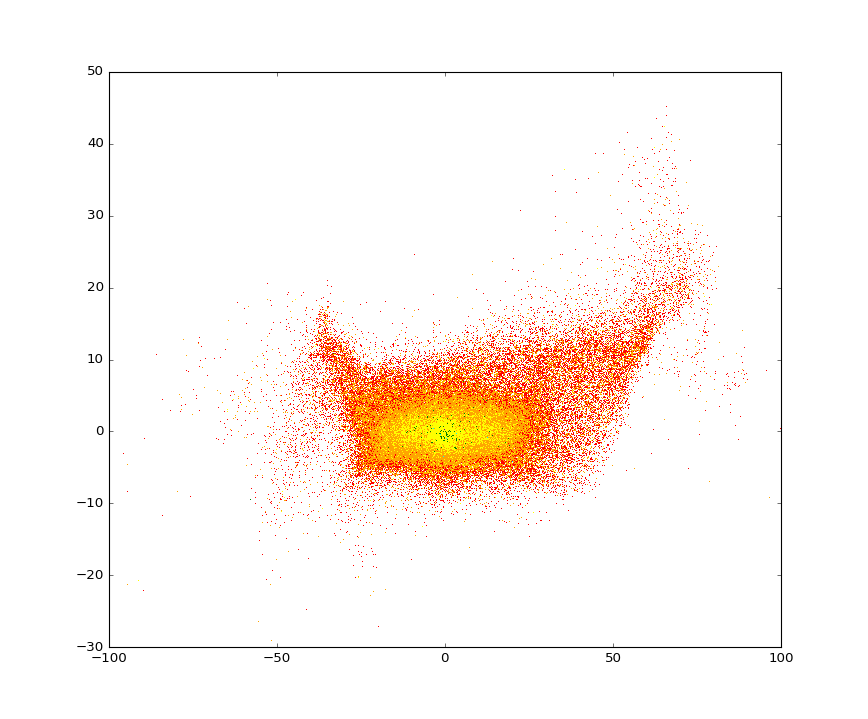

In [8]:
# Plot M31 side view
plt.figure()

data0 = GetData("M31_275.txt")
bin_t0 = binmaker(data0)
Radial0 = bin_t0.Radial_Bins(N_Rad)

dataf = GetData("M31_310.txt")
bin_tf = binmaker(dataf)
Radialf = bin_tf.Radial_Bins(N_Rad)

for i in range(N_Rad):
    index = np.where(Radial0 == i)
    plt.plot(dataf[index,1][0], dataf[index,2][0], ',', color=colors[i])
plt.savefig("M31_sideview.png")